# **Итоговый проект курса**,  1Т "Аналитик данных"

#### Задание:
Вы получили данные от интернет-магазина, который продает товары онлайн.<br>
Вашей задачей является анализ данных, выявление инсайтов и предоставление рекомендаций для улучшения показателей магазина.

#### Данные:
База данных (SQL): (ecommerce_data.db)<br>

__Orders__ — информация о заказах (ID заказа, ID клиента, дата заказа, сумма заказа, способ оплаты).  
__Customers__ — информация о клиентах (ID клиента, возраст, пол, город).  
__Products__ — информация о товарах (ID товара, название товара, категория, цена).  
__OrderItems__ — информация о товарах в заказах (ID заказа, ID товара, количество).  
__Visits__ — данные о посещениях сайта (ID клиента, дата визита, источник трафика, версия сайта).  

CSV файлы:<br>

__Promotions.csv__ — данные о маркетинговых акциях (ID акции, ID товара, дата начала акции, дата окончания акции).  
__Weather.csv__ — данные о погоде (дата, город, температура, осадки) для анализа влияния погодных условий на продажи.

### Импорт библиотек

In [1614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene
from statsmodels.stats.proportion import proportions_ztest
from pandas.errors import SettingWithCopyWarning

import warnings
from pprint import pprint
import calendar
import sqlite3
from contextlib import contextmanager
from datetime import datetime

### Глобальные настройки, объекты, функции и переменные

In [1615]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


class MyDataBase:

    def __init__(self, db_name='../datasets/ecommerce_data.db'):
        self.db_name = db_name

    def get_data(self, request):
        try:
            conn = sqlite3.connect(self.db_name)
            data = pd.read_sql_query(request, conn)
            return data
        except Exception as error:
            print(error)
        finally:
            conn.close()

    def to_db_from_csv(self, df, create_request=None, table_name=None):
        try:
            conn = sqlite3.connect(self.db_name)
            if create_request:
                cursor = conn.cursor()
                cursor.execute(create_request)
            if table_name:
                df.to_sql(table_name, conn, if_exists='replace', index=False)
        except Exception as error:
            print(error)
        finally:
            conn.close()


my_db = MyDataBase()


def get_info(df, info_df={}):

    info_df['0. Размер DataFrame'] = df.shape
    info_df['1. Индексы DataFrame'] = df.index
    info_df['2. Колонки DataFrame'] = list(df.columns.values)
    info_df['3. Числовые колонки'] = dict(df.select_dtypes(include=[int, float, complex]).dtypes)
    info_df['4. Строковые колонки'] = dict(df.select_dtypes(include=[object]).dtypes)
    info_df['5. Колонки с пропусками'] = list(df.columns[df.isnull().any()])
    info_df['6. Строки с пропусками'] = list(df[df.isnull().any(axis=1)].index.values)
    info_df['7. Колличество строк без пропусков'] = len(df.value_counts())
    info_df['8. Колличество полных дубликатов'] = len(df[df.duplicated(keep=False)])
    info_df['9. Колличество занимаемой памяти'] = f"{round(df.memory_usage(deep=True).sum() / 1048576, 2)} мегабайт"
    info_df['Колонка: тип данных'] = dict(zip(df.columns, df.dtypes))

    print(f'\n######################################## Информация о DataFrame ################################################')
    display(df.head(2))
    pprint(info_df, width=400, compact=True)
    display(df.tail(2))
    print('\n#################################################################################################################')

#### 1. <u>Исследование данных и предобработка</u>

*Проведите первичный анализ всех доступных данных (SQL, CSV)<br>*
*Проверьте наличие пропусков и дубликатов.<br>*
*Опишите структуру данных, выделите ключевые переменные.*

In [1616]:
df_Promotions = pd.read_csv('../datasets/Promotions.csv')
df_Weather = pd.read_csv('../datasets/Weather.csv')
df_orders = my_db.get_data('SELECT * FROM orders')
df_order_items = my_db.get_data('SELECT * FROM order_items')
df_customers = my_db.get_data('SELECT * FROM customers')
df_products = my_db.get_data('SELECT * FROM products')
df_visits = my_db.get_data('SELECT * FROM visits')

# Расскоментировать нужный вызов , чтобы посмотреть info по датафрайму

# get_info(df_Promotions)            # df_Promotions
# get_info(df_Weather)               # df_Weather
# get_info(df_orders)                # df_orders
# get_info(df_order_items)           # df_order_items
# get_info(df_customers)             # df_customers
# get_info(df_products)              # df_products
# get_info(df_visits)                # df_visits


df_Promotions['end_date'] = pd.to_datetime(df_Promotions['end_date'])
df_Promotions['start_date'] = pd.to_datetime(df_Promotions['start_date'])
df_Weather['date'] = pd.to_datetime(df_Weather['date'])
df_Weather['precipitation'] = df_Weather['precipitation'].fillna('Нет осадков')
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
df_visits['visit_date'] = pd.to_datetime(df_visits['visit_date'])

table_name = 'promotions'
create_request=f"CREATE TABLE IF NOT EXISTS {table_name} ({','.join(df_Promotions.columns)})"
my_db.to_db_from_csv(df_Promotions, create_request)
my_db.to_db_from_csv(df_Promotions, table_name=table_name)

table_name = 'weather'
create_request=f"CREATE TABLE IF NOT EXISTS {table_name} ({','.join(df_Weather.columns)})"
my_db.to_db_from_csv(df_Weather, create_request)
my_db.to_db_from_csv(df_Weather, table_name=table_name)

table_name = 'orders'
my_db.to_db_from_csv(df_orders, table_name=table_name)

table_name = 'visits'
my_db.to_db_from_csv(df_visits, table_name=table_name)

table_name = 'visits'
my_db.to_db_from_csv(df_visits, table_name=table_name)

*Загрузил все данные в датафреймы<br>*
*Перевел тип данных во всех колонках всех датафремов к `datetime`<br>*
*Заменил пропуски в колонке `precipitation` датафрайма `df_Weather` на  строку `Нет осадков`<br>*
*Дублирующие строки не обнаружил<br>*
*Добавил данные из csv-файлов в БД*

#### 2. <u>Обогащение данных</u>
*Загрузите данные о маркетинговых акциях из CSV файла и присоедините их к основным данным. (Сделал выше по коду)<br>*
*Извлеките данные о погоде для городов, представленных в базе данных.<br>*
*Присоедините их к данным о заказах по дате и городу.*

In [1617]:
query_1 = f'''
    WITH orders_customers AS (
         SELECT *
           FROM orders
                JOIN customers USING(customer_id))

    SELECT orders_customers.city AS city,
           orders_customers.order_date AS order_date,
           weather.precipitation AS precipitation
      FROM orders_customers
           JOIN weather ON weather.city = orders_customers.city
                       AND weather.date = orders_customers.order_date
'''

my_db.get_data(query_1)

,city,order_date,precipitation
0,Saint Petersburg,2024-07-03 00:00:00,Нет осадков
1,Moscow,2023-10-20 00:00:00,Snow
2,Novosibirsk,2023-11-02 00:00:00,Snow
3,Moscow,2024-08-15 00:00:00,Нет осадков
4,Moscow,2024-05-26 00:00:00,Rain
...,...,...,...
3408,Yekaterinburg,2024-03-23 00:00:00,Rain
3409,Moscow,2023-10-01 00:00:00,Rain
3410,Moscow,2023-11-30 00:00:00,Нет осадков
3411,Moscow,2024-02-07 00:00:00,Нет осадков


#### 3. <u>Анализ продаж</u>

*Определите влияние маркетинговых акций на продажи.*<br>
*Какие товары лучше продавались во время акций?<br>*
*Выявите, как погодные условия влияли на количество заказов в разных городах.<br>* 
*Например, увеличивались ли продажи в дождливые дни?*

In [1618]:
query_2 = f'''
     SELECT p.product_name,
            p.category,
            SUM(oi.quantity) AS total_quantity_sold,
            CASE
            WHEN o.order_date BETWEEN pr.start_date AND pr.end_date THEN 'YES'
            ELSE 'NO'
            END AS promotion_status
       FROM orders AS o
            JOIN order_items oi ON o.order_id = oi.order_id
            JOIN products p ON oi.product_id = p.product_id
            LEFT JOIN promotions pr ON oi.product_id = pr.product_id
      GROUP BY p.product_name, p.category, promotion_status
      ORDER BY p.product_name, promotion_status
'''


result_2 = my_db.get_data(query_2)
best_promotion = []

for i in result_2[result_2['promotion_status']=='YES'].values:
    for j in i:
        res = result_2[result_2['product_name'] == j].reset_index()
        if len(res) == 2:
            if res.loc[0, 'total_quantity_sold'] < res.loc[1, 'total_quantity_sold']:
               best_promotion.append(res.loc[1, 'product_name'])

print(f'''
     Товары , которые лучше продавались во время акций:
     {', '.join(best_promotion)}
     ''')


query_3 = f'''
     SELECT w.city,
            w.date,
            w.temperature,
            w.precipitation,
            COUNT(o.order_id) AS total_orders
       FROM orders o
            JOIN customers c ON o.customer_id = c.customer_id
            JOIN weather w ON c.city = w.city AND DATE(o.order_date) = DATE(w.date)
      GROUP BY w.city, w.date, w.temperature, w.precipitation
      ORDER BY w.city, w.date
'''


result_3 = my_db.get_data(query_3)
res = result_3.groupby(by=['city', 'precipitation']).agg(sum_count_orders=('total_orders', 'sum'), count_order=('total_orders', 'count'))
res['sum_by_city'] = res.groupby('city')['sum_count_orders'].transform('sum')
res['percent_order %'] = round(res['sum_count_orders']/res['sum_by_city']*100, 2)
display(res)


     Товары , которые лучше продавались во время акций:
     Bank, It, Parent, Receive, Similar, Small, Theory, Visit, World
     


sum_count_orders  count_order  sum_by_city  \
city             precipitation                                               
Moscow           Rain                        214           81          801   
                 Snow                        157           63          801   
                 Нет осадков                 430          178          801   
Novosibirsk      Rain                        234           89          856   
                 Snow                        179           69          856   
                 Нет осадков                 443          171          856   
Saint Petersburg Rain                        212           81          906   
                 Snow                        163           60          906   
                 Нет осадков                 531          189          906   
Yekaterinburg    Rain                        236           94          850   
                 Snow                        140           55          850   
                 Нет осадков                 474          181          850   

                                percent_order %  
city             precipitation                   
Moscow           Rain                     26.72  
                 Snow                     19.60  
                 Нет осадков              53.68  
Novosibirsk      Rain                     27.34  
                 Snow                     20.91  
                 Нет осадков              51.75  
Saint Petersburg Rain                     23.40  
                 Snow                     17.99  
                 Нет осадков              58.61  
Yekaterinburg    Rain                     27.76  
                 Snow                     16.47  
                 Нет осадков              55.76

#### 4. <u>Сегментация клиентов</u>
*Проведите сегментацию клиентов по частоте покупок и сумме потраченных средств.<br>* 
*Определите, какие сегменты наиболее ценны для бизнеса.<br>* 
*Проанализируйте влияние акций на поведение клиентов из разных сегментов.*

Сделал сегментацию клиентов:
- Сегментация по кол-ву заказов
    - `TOP` *более 6*
    - `MIDLE` *от 3 до 6*
    - `LOW` *менее 3*
- Сегментация по сумме заказов
    - `TOP` б*олее 10000*
    - `MIDLE` *от 5000 до 10000*
    - `LOW` *менее 5000*

In [1619]:
query_4 = f'''
    WITH customer_count AS (
        SELECT c.customer_id,
               COUNT(o.order_id) AS count_orders
          FROM customers c
               JOIN orders o ON c.customer_id = o.customer_id
         GROUP BY c.customer_id),

    segment_counts AS (
        SELECT customer_id,
            CASE
            WHEN count_orders > 6 THEN 'TOP'
            WHEN count_orders BETWEEN 3 AND 6 THEN 'MIDLE'
            ELSE 'LOW'
            END AS segment_count
        FROM customer_count)

    SELECT segment_count,
           COUNT(customer_id) AS customer_count
      FROM segment_counts
     GROUP BY segment_count
'''


query_5 = f'''
    WITH customer_sum AS (
        SELECT c.customer_id,
               SUM(o.order_amount) AS sum_orders
          FROM customers c
               JOIN orders o ON c.customer_id = o.customer_id
         GROUP BY c.customer_id),

    segment_sum AS (
        SELECT customer_id,
            CASE
            WHEN sum_orders > 10000 THEN 'TOP'
            WHEN sum_orders BETWEEN 5000 AND 10000 THEN 'MIDLE'
            ELSE 'LOW'
            END AS segment_sum
        FROM customer_sum)

    SELECT segment_sum,
           COUNT(customer_id) AS customer_count
      FROM segment_sum
     GROUP BY segment_sum
'''

result_4 = my_db.get_data(query_4)
result_5 = my_db.get_data(query_5)

result_4.merge(result_5, left_index=True, right_index=True)

,segment_count,customer_count_x,segment_sum,customer_count_y
0,LOW,305,LOW,389
1,MIDLE,607,MIDLE,368
2,TOP,55,TOP,210


#### 5. <u>Анализ трафика</u>

*Проанализируйте, какие источники трафика приводят наиболее платежеспособных клиентов.<br>* 
*Влияют ли маркетинговые акции на привлечение клиентов через определенные каналы?*

In [1620]:
query_6 = f'''
    SELECT c.customer_id,
           o.order_amount,
           v.traffic_source
      FROM customers c
           JOIN orders o ON c.customer_id = o.customer_id
           JOIN visits v ON v.customer_id = c.customer_id
     GROUP BY c.customer_id
     ORDER BY order_amount DESC
'''

result_6 = my_db.get_data(query_6)
display(result_6.head())
print(f'''
      Наиболее платежеспособных клиентов приходят по трафику AdWords, Email (топ 5)
      В сумме клиенты с таким трафиков тратят больше остальных
      ''')

,customer_id,order_amount,traffic_source
0,998,5922.66,AdWords
1,107,5895.03,Email
2,892,5718.05,AdWords
3,116,5542.41,AdWords
4,516,5499.52,AdWords



      Наиболее платежеспособных клиентов приходят по трафику AdWords, Email (топ 5)
      В сумме клиенты с таким трафиков тратят больше остальных
      


#### 6. <u>Поведение клиентов</u>

*Найдите среднее количество дней между заказами для активных клиентов.<br>* 
*Как меняется этот показатель в зависимости от участия в акциях?<br>*
*Проведите анализ по возрастным группам: какие товары и категории чаще покупают разные возрастные категории?<br>* 
*Как на это влияют акции?*

In [1621]:
df_orders = my_db.get_data('SELECT * FROM orders')
df_order_items = my_db.get_data('SELECT * FROM order_items')
df_customers = my_db.get_data('SELECT * FROM customers')
df_products = my_db.get_data('SELECT * FROM products')
df_promotions = my_db.get_data('SELECT * FROM promotions')

df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
df_promotions['start_date'] = pd.to_datetime(df_promotions['start_date'])
df_promotions['end_date'] = pd.to_datetime(df_promotions['end_date'])

df_orders = df_orders.sort_values(by=['customer_id', 'order_date'])
df_orders['previous_order_date'] = df_orders.groupby('customer_id')['order_date'].shift(1)
df_orders['days_between'] = (df_orders['order_date'] - df_orders['previous_order_date']).dt.days
active_customers = df_orders[df_orders['previous_order_date'].notnull()]
avg_days_between_orders = active_customers['days_between'].mean()

df_customers['age_group'] = pd.cut(df_customers['age'], bins=[0, 25, 50, 100],
                                   labels=['Молодые', 'Средний возраст', 'Взрослые'], right=False)

df = df_orders.merge(df_order_items, on='order_id') \
              .merge(df_customers, on='customer_id') \
              .merge(df_products, on='product_id', how='left') \
              .merge(df_promotions, on='product_id', how='left')

df['promotion_status'] = df.apply(
    lambda row: 'YES' if pd.notnull(row['start_date']) and row['start_date'] <= row['order_date'] <= row['end_date']
    else 'NO', axis=1)

grouped = df.groupby(['age_group', 'category', 'promotion_status'])['product_id'].count().reset_index()
grouped.rename(columns={'product_id': 'total_purchases'}, inplace=True)

# display(df_orders)
# display(grouped)

print(f"Среднее количество дней между заказами для активных клиентов: {int(avg_days_between_orders)}")
print(f'''
       Молодые чаще всего покупают: Clothing
       Средний возраст чаще всего покупают: Clothing, Home
       Взрослые чаще всего покупают: Clothing, Home
''')


Среднее количество дней между заказами для активных клиентов: 68

       Молодые чаще всего покупают: Clothing
       Средний возраст чаще всего покупают: Clothing, Home
       Взрослые чаще всего покупают: Clothing, Home



#### 7. <u>Визуализация данных</u>

*Постройте графики, которые визуализируют директору ключевые метрики:<br>* 
*динамику продаж по месяцам, влияние погоды и акций на продажи, распределение возрастов клиентов и т.д.<br>*
*Покажите все, что по вашему мнению, важно подсветить директору для принятия управленческих решений.*

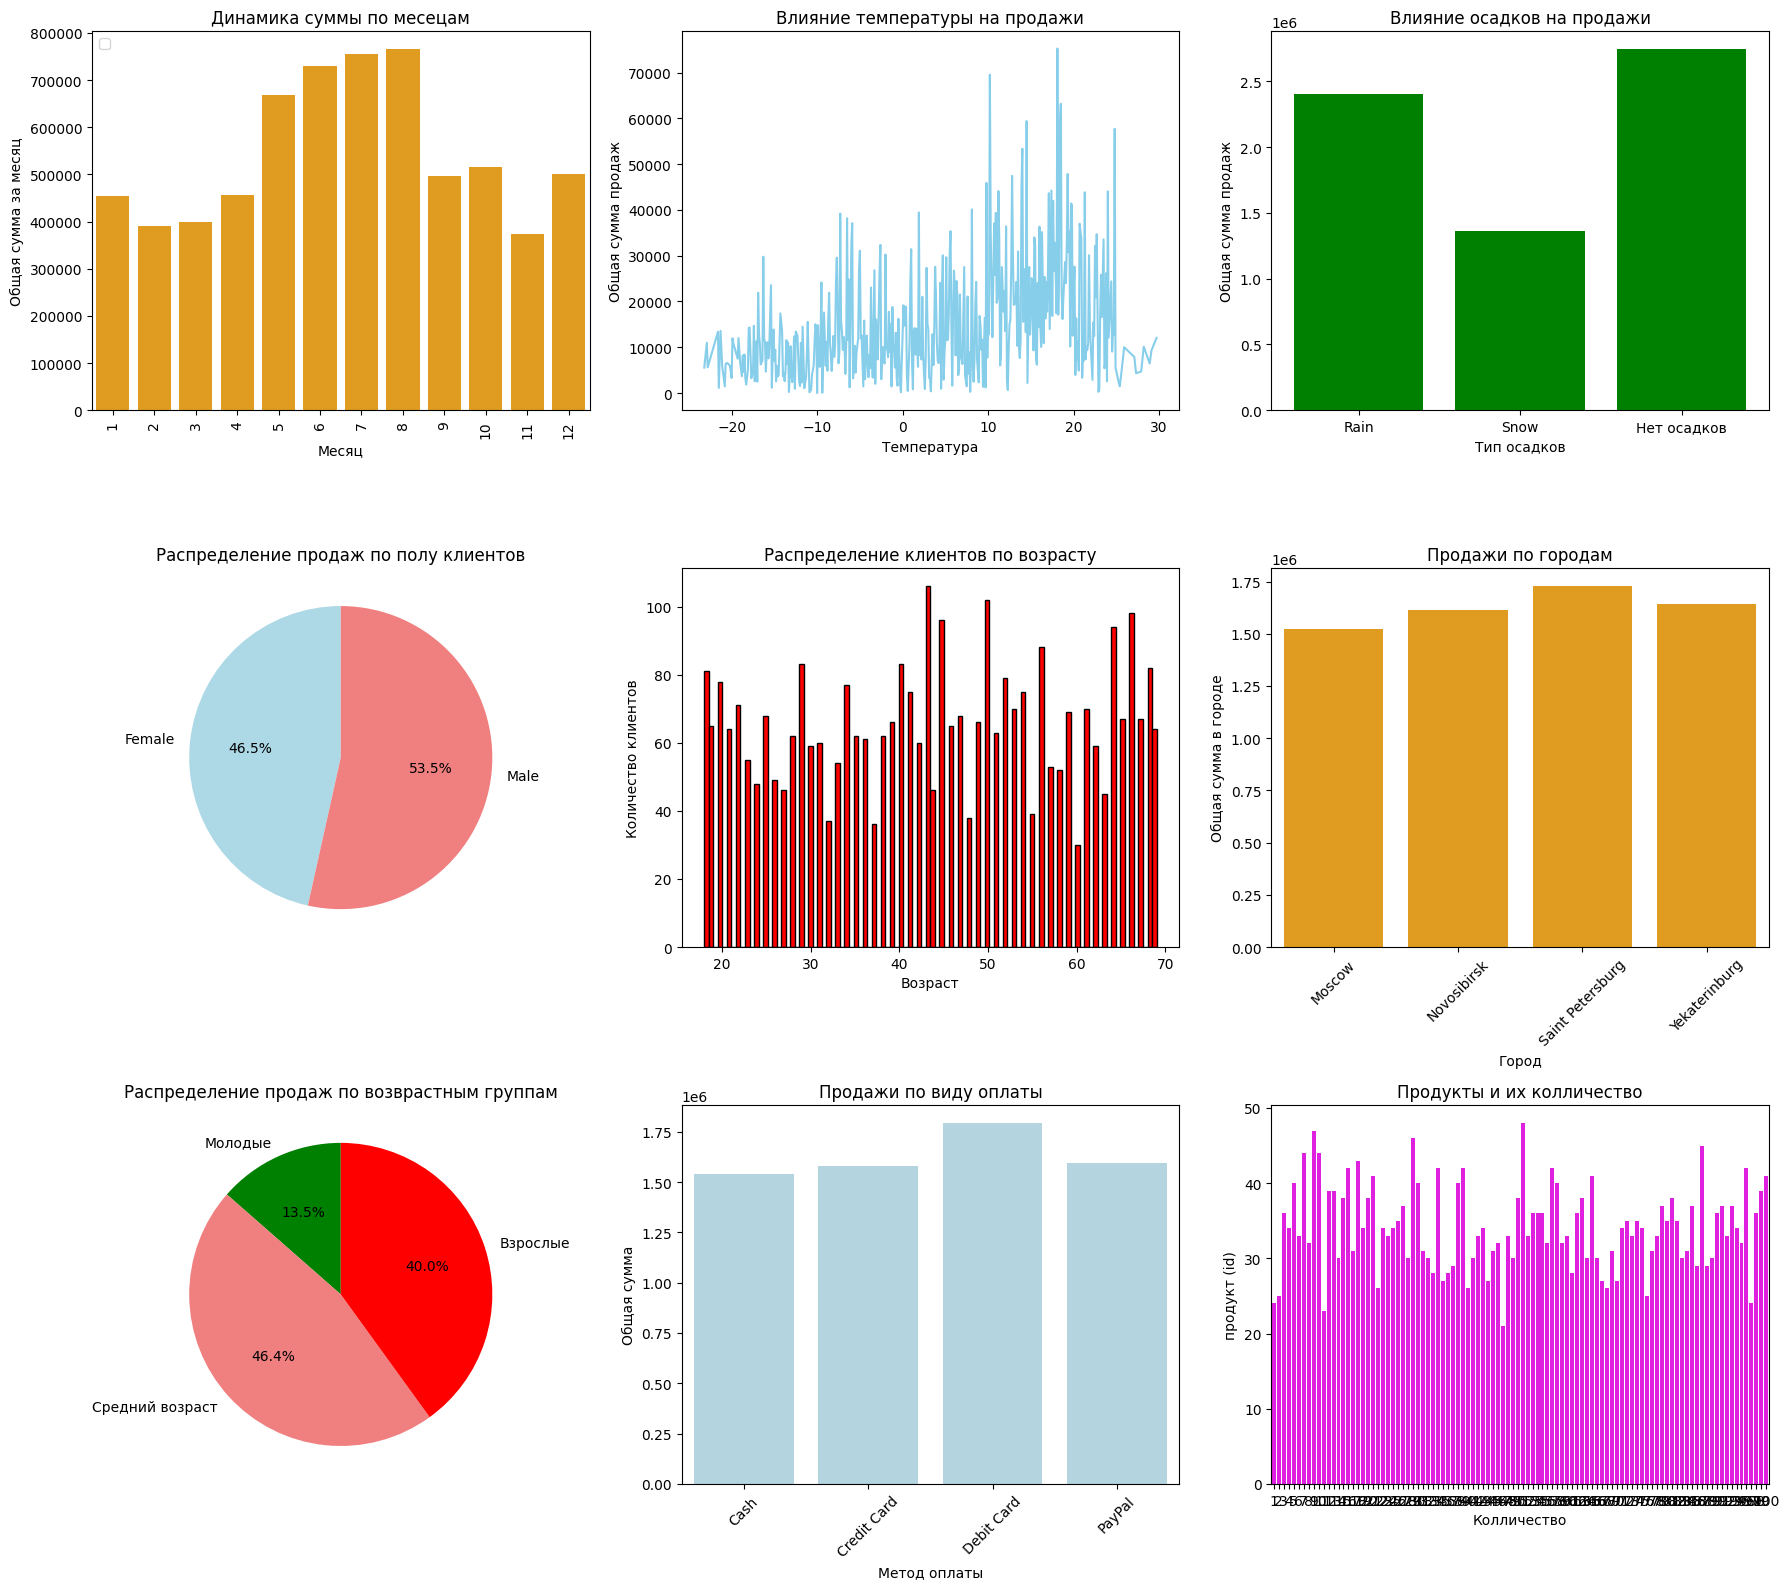

In [1622]:
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
df_Weather['date'] = pd.to_datetime(df_Weather['date'])
df_orders_customers = pd.merge(df_orders, df_customers, on='customer_id', how='left')
df_orders_items = pd.merge(df_orders_customers, df_order_items, on='order_id', how='left')
df_combined = pd.merge(df_orders_items, df_Weather, left_on=['order_date', 'city'], right_on=['date', 'city'], how='left')
df_combined.drop('date', axis=1, inplace=True)

df_orders['month'] = df_orders['order_date'].dt.month
month_orders = df_orders.groupby(by='month').agg(all_amount=('order_amount', 'sum'))
month_orders['month_name'] = list(calendar.month_name)[1:]
temperature_sales = df_combined.groupby('temperature').agg(total_sales=('order_amount', 'sum')).reset_index()
precipitation_sales = df_combined.groupby('precipitation').agg(total_sales=('order_amount', 'sum')).reset_index()
gender_sales = df_combined.groupby('gender').agg(total_sales=('order_amount', 'sum')).reset_index()
city_sales = df_combined.groupby('city').agg(total_sales=('order_amount', 'sum')).reset_index()
count_age_group = df_combined.groupby('age_group').agg(order_count=('order_id', 'count')).reset_index()
payment_method_sum = df_combined.groupby('payment_method').agg(sum_order=('order_amount', 'sum')).reset_index()
top_product_id = df_combined.groupby('product_id').agg(count_order=('order_id', 'count')).reset_index()


fig, ax = plt.subplots(3, 3, figsize=(18, 16))


sns.barplot(x=month_orders['month_name'], y=month_orders['all_amount'], color='orange', ax=ax[0, 0])
ax[0, 0].set_xlabel('Месяц')
ax[0, 0].set_xticklabels(month_orders['month_name'], rotation=45)
ax[0, 0].set_ylabel('Общая сумма за месяц')
ax[0, 0].set_title('Динамика суммы по месецам')
ax[0, 0].legend(ncol=1, loc="upper left", frameon=True)

ax[0, 1].plot(temperature_sales['temperature'], temperature_sales['total_sales'], color='skyblue')
ax[0, 1].set_xlabel('Температура')
ax[0, 1].set_ylabel('Общая сумма продаж')
ax[0, 1].set_title('Влияние температуры на продажи')

ax[0, 2].bar(precipitation_sales['precipitation'], precipitation_sales['total_sales'], color='green')
ax[0, 2].set_xlabel('Тип осадков')
ax[0, 2].set_ylabel('Общая сумма продаж')
ax[0, 2].set_title('Влияние осадков на продажи')

ax[1, 0].pie(gender_sales['total_sales'],
             labels=gender_sales['gender'],
             autopct='%1.1f%%',
             startangle=90,
             colors=['lightblue', 'lightcoral'])
ax[1, 0].set_title('Распределение продаж по полу клиентов')

ax[1, 1].hist(df_combined['age'], bins=100, color='red', edgecolor='black')
ax[1, 1].set_xlabel('Возраст')
ax[1, 1].set_ylabel('Количество клиентов')
ax[1, 1].set_title('Распределение клиентов по возрасту')


sns.barplot(x=city_sales['city'], y=city_sales['total_sales'], color='orange', ax=ax[1, 2])
ax[1, 2].set_xlabel('Город')
ax[1, 2].set_xticklabels(city_sales['city'], rotation=45)
ax[1, 2].set_ylabel('Общая сумма в городе')
ax[1, 2].set_title('Продажи по городам')

ax[2, 0].pie(count_age_group['order_count'],
             labels=count_age_group['age_group'],
             autopct='%1.1f%%',
             startangle=90,
             colors=['green', 'lightcoral', 'red'])
ax[2, 0].set_title('Распределение продаж по возврастным группам')

sns.barplot(x=payment_method_sum['payment_method'], y=payment_method_sum['sum_order'], color='lightblue', ax=ax[2, 1])
ax[2, 1].set_xlabel('Метод оплаты')
ax[2, 1].set_xticklabels(payment_method_sum['payment_method'], rotation=45)
ax[2, 1].set_ylabel('Общая сумма')
ax[2, 1].set_title('Продажи по виду оплаты')


sns.barplot(x=top_product_id['product_id'], y=top_product_id['count_order'], color='magenta', ax=ax[2, 2])
ax[2, 2].set_xlabel('Колличество')
ax[0, 0].set_xticklabels(top_product_id['product_id'], rotation=90)
ax[2, 2].set_ylabel('продукт (id)')
ax[2, 2].set_title('Продукты и их колличество')

plt.tight_layout()
plt.show()

#### 8. <u>Продуктовые метрики</u>
*Рассчитайте основные продуктовые метрики:*
- DAU, 
- CAC (стоимость привлечения клиента), 
- LTV (пожизненная ценность клиента).

In [1623]:
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])

dau_all = df_orders['customer_id'].nunique()
dau_year = df_orders.groupby(df_orders['order_date'].dt.year)['customer_id'].nunique().reset_index()
dau_month = df_orders.groupby(df_orders['order_date'].dt.month)['customer_id'].nunique().reset_index()
dau_day = df_orders.groupby(df_orders['order_date'].dt.day)['customer_id'].nunique().reset_index()

sum_visits_cost = df_visits['visit_cost'].sum()
unique_customers = df_visits['customer_id'].nunique()
cac = sum_visits_cost / unique_customers

customer_value = df_orders.groupby('customer_id').agg(
    total_value=('order_amount', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()
avg_value_per_customer = customer_value['total_value'].mean()
avg_orders_per_customer = customer_value['total_orders'].mean()
ltv = avg_value_per_customer * avg_orders_per_customer


dau_dict = {'DAU по году:': dau_year, 'DAU по месяцу:': dau_month, 'DAU по дням:': dau_day}
print(f"DAU общее: {dau_all}", end=';')
for name, dau in dau_dict.items():
    print('\n')
    print(name)
    for i, j in dau.values:
        print(f"{i} = {j}", end='; ')

print('\n')
print(f"CAC (Стоимость привлечения клиента): {cac}")
print()
print(f"LTV (В среднем безнесу приносит денег): {ltv}")

DAU общее: 967;

DAU по году:
2023 = 710; 2024 = 882; 

DAU по месяцу:
1 = 234; 2 = 217; 3 = 258; 4 = 227; 5 = 279; 6 = 238; 7 = 255; 8 = 253; 9 = 246; 10 = 248; 11 = 253; 12 = 273; 

DAU по дням:
1 = 102; 2 = 103; 3 = 124; 4 = 101; 5 = 77; 6 = 110; 7 = 109; 8 = 98; 9 = 116; 10 = 105; 11 = 118; 12 = 109; 13 = 115; 14 = 126; 15 = 91; 16 = 100; 17 = 95; 18 = 112; 19 = 125; 20 = 118; 21 = 101; 22 = 89; 23 = 121; 24 = 103; 25 = 93; 26 = 102; 27 = 93; 28 = 102; 29 = 107; 30 = 92; 31 = 52; 

CAC (Стоимость привлечения клиента): 34.43822

LTV (В среднем безнесу приносит денег): 23746.945251243465


#### 9. <u>A/B тестирование</u>

*Компания тестирует две разные версии главной страницы своего сайта — версию A (стандартная страница)<br>* 
*и версию B (страница с обновленным дизайном, где более активно представлены рекламные акции).* 

*Для каждой версии страницы собираются данные о визитах пользователей и их конверсии в заказы.<br>* 
*Ваша задача — провести A/B тест и определить, есть ли статистически значимая разница в конверсии между этими двумя версиями.*

In [1624]:
df_visits['conversion'] = df_visits['customer_id'].isin(df_orders['customer_id']).astype(int)

conversion_summary = df_visits.groupby('version').agg(
    visits=('visit_id', 'count'),
    conversions=('conversion', 'sum')).reset_index()

conversion_summary['conversion_rate'] = conversion_summary['conversions'] / conversion_summary['visits']

conversions = conversion_summary['conversions'].values
visits = conversion_summary['visits'].values
z_stat, p_value = proportions_ztest(conversions, visits)

bad = "Между версиями A и B есть статистически значимая разница в конверсии."
good = "Статистически значимой разницы в конверсии между версиями A и B нет."


print(f"z-статистика: {z_stat:.2f}")
print(f"p-значение: {p_value:.4f}")
print(bad if p_value < 0.05 else good)


z-статистика: 1.85
p-значение: 0.0649
Статистически значимой разницы в конверсии между версиями A и B нет.


#### 10. <u>Рекомендации</u>

*На основе анализа данных, предложите три ключевые рекомендации по улучшению показателей магазина,<br>*
*учитывая влияние акций и внешних факторов (например, погоды).*

- Рекомендую провести дополнительное тестирование
- Возможно изменить версию сайта и добавить что-то новое , т.к А/B-тест показал не существенную статю разницу
- Продолжать проводить маркейтенговые акции
- Использовать данные о погоде для выдачи актуальной информации на сайте
- Настроить рекламные компании с учетов возраста и пола клиента
- Рекомендую больше платить аналитикам - наша работа принесет вам очень много денег !